In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import skimage
import skimage.io
import scipy.io as sio
import skimage.transform
import sys
import tensorflow as tf
import numpy as np
import sys
import os
import scipy.io as sio
import re
import time
from tqdm import tqdm
np.random.seed(0)

In [2]:
outputChannels = 2
classType = 'unified_CR'
# 0 leaf --> background?
indices = [0]
savePrefix = "direction_" + classType + "_unified_CR_pretrain"



train = False


In [3]:
from ioUtils import *

ModuleNotFoundError: No module named 'ioUtils'

In [ ]:
valFeeder = Batch_Feeder(dataset_path="../../watershednet/data/for_training/42/", 
                           indices=indices,
                           subset='test',
                           batchSize=5,
                           padWidth=None,
                           padHeight=None, 
                           flip=False,
                           keepEmpty=False,
                           train=True,
                           img_shape = (384,384))
valFeeder.set_paths()

        

In [ ]:
# train_model(model=model, outputChannels=outputChannels,
#             learningRate=learningRate,
#             trainFeeder=trainFeeder, valFeeder=valFeeder,
#             modelSavePath="../models/direction", savePrefix=savePrefix,
#             initialIteration=initialIteration)

In [ ]:
!ls ../models/direction

In [7]:
modelWeightPaths = ["../models/direction/direction_unified_CR_unified_CR_pretrain_150.mat"]

In [8]:
from train_direction import initialize_model

In [9]:
#modelWeightPaths = ["./cityscapes/models/direction/direction3_unified_ss_wide_pretrain_VGGFIX_020.mat"]

model = initialize_model(outputChannels=outputChannels, wd=0, modelWeightPaths=modelWeightPaths)

# feeder = Batch_Feeder(dataset="cityscapes", indices=indices, train=train, batchSize=batchSize, padWidth=None, padHeight=None)
# feeder.set_paths(idList=read_ids("./cityscapes/splits/vallist.txt"),
#                  imageDir="./cityscapes/inputImages/val",
#                  ssDir="./cityscapes/unified/ssMaskFineGT/val")



In [10]:
import math
batchSize = 8

In [11]:
with tf.Session() as sess:
    tfBatchImages = tf.placeholder("float", shape=[None, 384, 384, 3])
    tfBatchGT = tf.placeholder("float", shape=[None, 384, 384, 2])
    tfBatchSS = tf.placeholder("float", shape=[None, 384, 384])

    with tf.name_scope("model_builder"):
        print ("attempting to build model")
        model.build(tfBatchImages, tfBatchSS)
        print ("built the model")
    sys.stdout.flush()

    init = tf.initialize_all_variables()
    sess.run(init)
    
    
    for i in tqdm(range(int(math.floor(valFeeder.total_samples() / batchSize)))):

        imageBatch, gtBatch, ssBatch = valFeeder.next_batch()

        outputBatch = sess.run(model.output, feed_dict={tfBatchImages: imageBatch,
                               tfBatchGT: gtBatch,
                               tfBatchSS: ssBatch})
        
        

#         for j in range(len(idBatch)):
#             outputFilePath = os.path.join(outputSavePath, idBatch[j]+'.mat')
#             outputFileDir = os.path.dirname(outputFilePath)

#             if not os.path.exists(outputFileDir):
#                 os.makedirs(outputFileDir)

#             sio.savemat(outputFilePath, {"dir_map": outputBatch[j]}, do_compression=True)

#             print ("processed image %d out of %d"%(j+batchSize*i, feeder.total_samples()))



attempting to build model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

loaded direction/conv1_1/weights


loaded direction/conv1_1/biases
loaded direction/conv1_2/weights
loaded direction/conv1_2/biases

loaded direction/conv2_1/weights
loaded direction/conv2_1/biases
loaded direction/conv2_2/weights
loaded direction/conv2_2/biases
loaded direction/conv3_1/weights
loaded direction/conv3_1/biases
loaded direction/conv3_2/weights
loaded direction/conv3_2/biases
loaded direction/conv3_3/weights
loaded direction/conv3_3/biases

loaded direction/conv4_1/weights
loaded direction/conv4_1/biases
loaded direction/conv4_2/weights
loaded direction/conv4_2/biases
loaded direction/conv4_3/weights
loaded direction/conv4_3/biases
loaded direction/conv5_1/weights
loaded direction/conv5_1/biases
loaded direction/conv5_2/weights
loaded direction/conv5_2/biases
loaded direction/conv5_3/weights
loaded direction/conv5_3/biases
built

100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


In [12]:
outputBatch.shape

(5, 384, 384, 2)

In [13]:
import matplotlib.pyplot as plt

In [14]:
img = outputBatch[1]
gt = gtBatch[1]

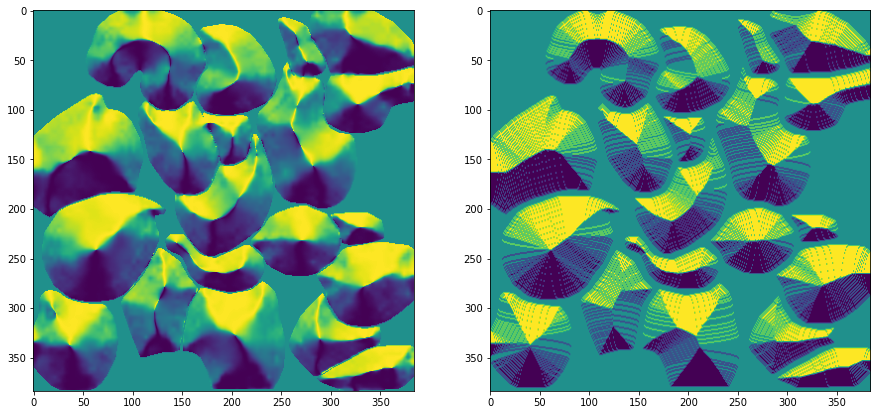

In [16]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img[:,:,0])
plt.subplot(122)
plt.imshow(gt[:,:,0])

In [ ]:
def forward_model(model, feeder, outputSavePath):
    with tf.Session() as sess:
        tfBatchImages = tf.placeholder("float", shape=[None, 384, 384, 3])
        tfBatchGT = tf.placeholder("float", shape=[None, 384, 384, 2])
        tfBatchSS = tf.placeholder("float", shape=[None, 384, 384])

        with tf.name_scope("model_builder"):
            print ("attempting to build model")
            model.build(tfBatchImages, tfBatchSS)
            print ("built the model")
        sys.stdout.flush()

        init = tf.initialize_all_variables()
        sess.run(init)

        for i in range(int(math.floor(feeder.total_samples() / batchSize))):
            imageBatch, ssBatch, ssMaskBatch, idBatch = feeder.next_batch()

            outputBatch = sess.run(model.output, feed_dict={tfBatchImages: imageBatch, tfBatchSS: ssBatch, tfBatchSSMask: ssMaskBatch})

            for j in range(len(idBatch)):
                outputFilePath = os.path.join(outputSavePath, idBatch[j]+'.mat')
                outputFileDir = os.path.dirname(outputFilePath)

                if not os.path.exists(outputFileDir):
                    os.makedirs(outputFileDir)

                sio.savemat(outputFilePath, {"dir_map": outputBatch[j]}, do_compression=True)

                print ("processed image %d out of %d"%(j+batchSize*i, feeder.total_samples()))


In [ ]:
forward_model(model, feeder=feeder,
              outputSavePath="./training/output/direction_ss")